In [1]:
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import time

import lightgbm as lgbm
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss
from sklearn.model_selection import GroupKFold
# from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from imblearn.under_sampling import RandomUnderSampler
from optuna import integration, logging
from itertools import product

In [2]:
tag = "ensemble"

train = pl.read_csv("data/train.csv")
test_feat = pl.read_csv("feat/feat_test.csv")
test_pred_df = pl.read_csv(f"pred/test_pred_df_{tag}.csv")

In [3]:
# trainにおける、各クラスのデータ件数率
weights_train = np.array(train["health"].value_counts().sort("health")["count"]) / len(train)
weights_train

array([0.17689151, 0.78818054, 0.03492794])

In [4]:
# F1-score期待値が最大となる閾値の探索
# dp0_lst = np.arange(0.00, 0.33, 1e-3)
# dp1_lst = np.arange(-0.46, -0.27, 1e-3)
dp0_lst = np.arange(0.12, 0.16, 1e-4)
dp1_lst = np.arange(-0.43, -0.41, 1e-4)


In [5]:
rec = []
dp0_dp1_lst = list(product(dp0_lst, dp1_lst))

for dp0, dp1 in tqdm(dp0_dp1_lst):
    # if not dp0 + dp1 >= -1/3: # 境界条件
    #     continue
            
    # 判定閾値をナイーブベース(1/3, 1/3)からスライド
    dp_df = test_pred_df.with_columns([pl.col("health_is_0") + dp0, 
                                       pl.col("health_is_1") + dp1, 
                                       pl.col("health_is_2") - dp0 - dp1])

    # スライドした閾値に基づくクラス分類
    pred_label = np.argmax(dp_df, axis=1) 

    # 各クラスに属するデータ件数率を求める
    weights_test = np.array([(pred_label == h).sum() for h in range(3)]) / len(test_pred_df)

    # train/testのデータ件数率の絶対誤差
    err = np.abs(weights_train - weights_test).sum()
    
    rec.append([dp0, dp1, err])

# to dataframe
rec_df = pl.DataFrame(np.array(rec), schema=["dp0", "dp1", "err"])
rec_df.write_csv("feat/grid_search_threshold.csv")

  0%|          | 0/500000 [00:00<?, ?it/s]

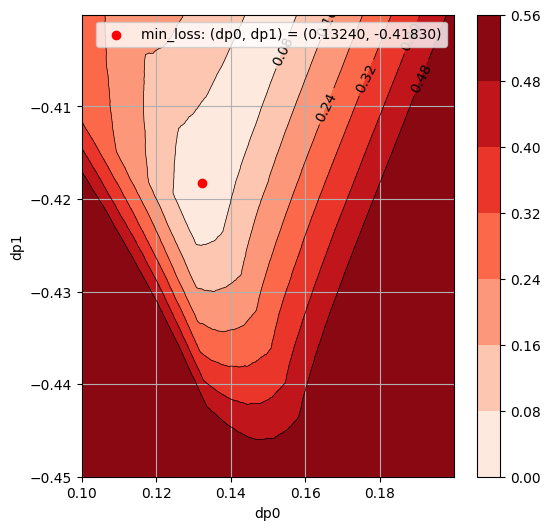

In [6]:
# loading
rec_df = pl.read_csv("feat/grid_search_threshold.csv")

# visualize with contour
dp0_grids, dp1_grids = np.meshgrid(dp0_lst, dp1_lst)

loss_lst = []
zvis_max = 0.5
# dp0min, dp0max = 0.135, 0.136
# dp1min, dp1max = -0.4205, -0.4195
            
z = np.array(rec_df["err"]).reshape(dp0_grids.shape[::-1]).T
zvis = np.stack([z, zvis_max*np.ones_like(z)]).min(axis=0)

# 最適パラメータの特定 & record
grid_min = np.where(z - z.min() < 1e-12)
dp0_opt = dp0_grids[grid_min][0]
dp1_opt = dp1_grids[grid_min][0]

# visualize
fig, ax = plt.subplots(figsize=(6, 6))
cs = ax.contour(dp0_grids, dp1_grids, zvis, colors="black", linewidths=0.5)
ax.clabel(cs)
cs = ax.contourf(dp0_grids, dp1_grids, zvis, cmap="Reds")
fig.colorbar(mappable=cs)
ax.set_xlabel("dp0")
ax.set_ylabel("dp1")
# ax.set_xlim(dp0min, dp0max)
# ax.set_ylim(dp1min, dp1max)
ax.grid()
ax.scatter(dp0_opt, dp1_opt, color="r", label=f"min_loss: (dp0, dp1) = ({dp0_opt:.5f}, {dp1_opt:.5f})")
ax.legend()
plt.show()
plt.close()

In [7]:
# 判定閾値をナイーブベース(1/3, 1/3)からスライド
dp_df = test_pred_df.with_columns([pl.col("health_is_0") + dp0_opt, 
                                   pl.col("health_is_1") + dp1_opt, 
                                   pl.col("health_is_2") - dp0_opt - dp1_opt])

# スライドした閾値に基づくクラス分類
pred_label = np.argmax(dp_df, axis=1) 

# submission file
submission = pl.DataFrame({"idx": test_feat["idx"], "PredictedLabel": pred_label})
submission.write_csv(f"submission_{tag}.csv", include_header=False)